In [4]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


In [5]:
train = pd.read_csv('preprocessed_train.csv')
test = pd.read_csv('preprocessed_test.csv')

# Evaluation


In [6]:
def time_evaluation(y_test, y_pred, model: str):
 
    print(f"Error metrics (measured in hours) for the {model} when predicting the next event's Unix timestamp")
    print('\n')
    print('Mean Absolute Error:', round(mean_absolute_error(y_test, y_pred)/3600),3)
    print('Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test, y_pred)/3600),3))
    print('R2 score:', round(r2_score(y_test, y_pred),3))
    
    
def event_evaluation(y_test, y_pred, model: str, avg="weighted"):

    precision = precision_score(y_test, y_pred, average=avg, zero_division=0)
    recall = recall_score(y_test, y_pred, average=avg, zero_division=0)
    F1_score = f1_score(y_test, y_pred, average=avg, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f'Error metrics for the {model} when predicting the next event')
    print('\n')
    print(f'Accuracy: {round(accuracy,3)}.')
    print(f'Precision: {round(precision,3)}')
    print(f'Recall: {round(recall,3)}')
    print(f'f1-score: {round(F1_score,3)}')
    print(confusion_matrix(y_test, y_pred))

# Data splitting and encoding

In [7]:
def encoder(df):
    """
    encode the columns that are needed in the models
    """
    event_encoder = LabelEncoder()

    events = df["event concept:name"].unique().tolist() + ['FIRST EVENT',"LAST EVENT"]
    event_encoder.fit(events)
    
    df[["event concept:name","prev_event", "2prev_event", 'next_event']] = df[["event concept:name", 
            "prev_event", "2prev_event", 'next_event']].apply(event_encoder.transform)
    
    return df

In [8]:
train = encoder(train)
test = encoder(test)

In [9]:
X_train = train[['event concept:name','prev_event', '2prev_event', 'prev_timestamp']]
y_train = train[['next_event', 'next_timestamp']]

X_test = test[['event concept:name','prev_event', '2prev_event', 'prev_timestamp']]
y_test = test[['next_event', 'next_timestamp']]

# select only 'next_timestamp' for predicting time and 'next_event' for events

# Event prediction

In [10]:
def RandomForestEvents(X_train, X_test, y_train, y_test):
    '''no grid search, no cv, or feature selection, do for final model
    '''
    
    X_train_event = X_train[['event concept:name','prev_event', '2prev_event']]
    y_train_event = y_train['next_event']

    X_test_event = X_test[['event concept:name','prev_event', '2prev_event']]
    y_test_event = y_test['next_event']
    
    forest_clf = RandomForestClassifier(n_estimators=10, bootstrap = False, criterion = 'gini', random_state=42)
    forest_clf.fit(X_train_event, y_train_event)
    
    y_pred = forest_clf.predict(X_test_event)

    return forest_clf, y_pred

In [11]:
forest_event, y_pred_event = RandomForestEvents(X_train, X_test, y_train, y_test)

In [12]:
confusion_matrix(y_test['next_event'], y_pred_event)

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,  420,    0,
           0,    0],
       [   0,   72,   34,    0,    0,    0,    0,    0,   34,    0,    0,
          15,    0,    0,    0,    0,    0,    0,    0,    0,    0,   10,
           0,   14],
       [   0,    2,   88,    0,    0,    0,    0,    0,    1,    0,    0,
           5,    0,    0,    0,    0,    0,    0,    0,    0,    0,    7,
           0,   76],
       [   0,    0,    0,   45,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   13,    0,    0,    0,    0,  112,    9,
          62,    1],
       [   0,    0,    0,    0,   49,    0,    0,  137,    0,    0,    0,
           0,    0,    0,    0,    5,    0,    0,  360,    3,   96,    8,
           5,   32],
       [   0,    0,    0,    0,    0,  226,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  180,    0,    0,    0,    0,    2,    0,
       

In [13]:
event_evaluation(y_test['next_event'], y_pred_event, 'Random forest classifier')

Error metrics for the Random forest classifier when predicting the next event


Accuracy: 0.785.
Precision: 0.772
Recall: 0.785
f1-score: 0.748
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0  420    0    0    0]
 [   0   72   34    0    0    0    0    0   34    0    0   15    0    0
     0    0    0    0    0    0    0   10    0   14]
 [   0    2   88    0    0    0    0    0    1    0    0    5    0    0
     0    0    0    0    0    0    0    7    0   76]
 [   0    0    0   45    0    0    0    0    0    0    0    0    0    0
     0   13    0    0    0    0  112    9   62    1]
 [   0    0    0    0   49    0    0  137    0    0    0    0    0    0
     0    5    0    0  360    3   96    8    5   32]
 [   0    0    0    0    0  226    0    0    0    0    0    0    0    0
     0  180    0    0    0    0    2    0    0    0]
 [   0    0    0    0    0    0 1140    0    0    0    0    0    0    0
     0    0    0    0    0    0   

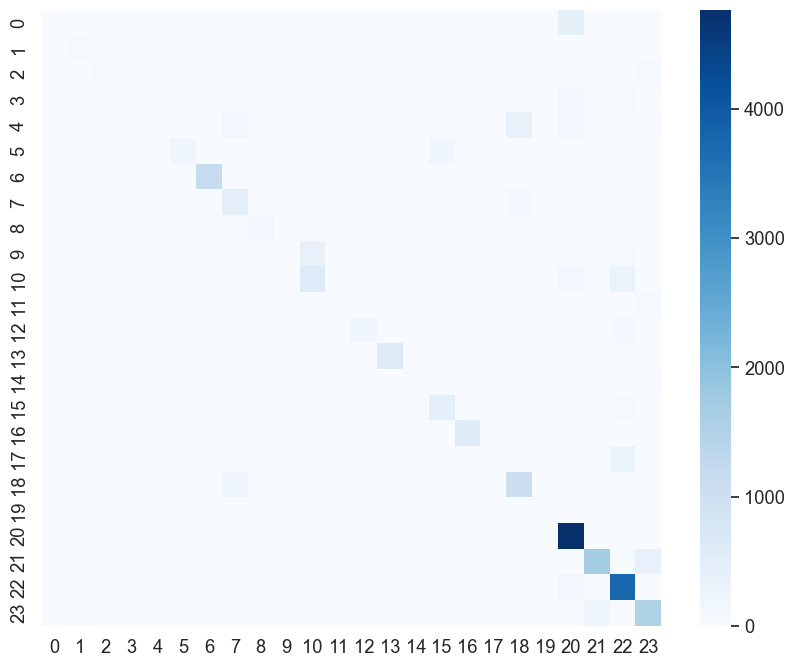

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test['next_event'], y_pred_event)

# plot confusion matrix as a heatmap
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm, fmt='g', cmap='Blues', ax=ax, annot_kws={"size": 14})
# ax.set_xlabel('Predicted labels', fontsize=14)
# ax.set_ylabel('True labels', fontsize=14)
# ax.set_title('Confusion Matrix', fontsize=16)
# ax.xaxis.set_ticklabels(labels, rotation=90)
# ax.yaxis.set_ticklabels(labels, rotation=0)
plt.show()

In [34]:
def event_evaluation(y_test, y_pred, model, avg="weighted", labels=None):
    precision = precision_score(y_test, y_pred, average=avg, zero_division=0)
    recall = recall_score(y_test, y_pred, average=avg, zero_division=0)
    F1_score = f1_score(y_test, y_pred, average=avg, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test['next_event'], y_pred_event)
    
    print(f'Error metrics for the {model} when predicting the next event')
    print('\n')
    print(f'Accuracy: {round(accuracy,3)}.')
    print(f'Precision: {round(precision,3)}')
    print(f'Recall: {round(recall,3)}')
    print(f'f1-score: {round(F1_score,3)}')
    
    # plot confusion matrix as a heatmap
    sns.set(font_scale=1.2)
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(cm, fmt='g', cmap='Blues', ax=ax, annot_kws={"size": 14})
    # ax.set_xlabel('Predicted labels', fontsize=14)
    # ax.set_ylabel('True labels', fontsize=14)
    # ax.set_title('Confusion Matrix', fontsize=16)
    # ax.xaxis.set_ticklabels(labels, rotation=90)
    # ax.yaxis.set_ticklabels(labels, rotation=0)
    plt.show()
    
    return cm


In [35]:
# define labels for the confusion matrix
labels = train['event concept:name'].unique().tolist() + ['FIRST EVENT', 'LAST EVENT']

# call the function and pass the labels parameter
cm = event_evaluation(y_test['next_event'], y_pred_event, 'Random forest classifier', labels=labels)


KeyError: 'next_event'

In [ ]:
from sklearn.model_selection import cross_val_score

# create a new random forest model with the same hyperparameters
forest_clf = RandomForestClassifier(n_estimators=10, bootstrap = False, criterion = 'gini', random_state=42)

# get the input features and labels
X = train[['event concept:name','prev_event', '2prev_event', 'prev_timestamp']]
y = train[['next_event']]

# perform 5-fold cross-validation and get the accuracy score for each fold
scores = cross_val_score(forest_clf, X, y.values.ravel(), cv=5, scoring='accuracy')

# print the accuracy scores for each fold
print('Accuracy scores for each fold:', scores)

# print the mean and standard deviation of the accuracy scores
print('Mean accuracy score:', scores.mean())
print('Standard deviation of accuracy scores:', scores.std())


Accuracy scores for each fold: [0.66631219 0.69429501 0.6929124  0.62385053 0.66253102]
Mean accuracy score: 0.6679802297591677
Standard deviation of accuracy scores: 0.02566704945086732


In [ ]:
forest_event.feature_importances_
# current + prev 2 events are all important

array([0.39591211, 0.32614465, 0.27794324])

# Time prediction

In [31]:
def RandomForestTime(X_train, X_test, y_train, y_test):
    '''no grid search, no cv, or feature selection, do for final model
    '''
    
    X_train_time = X_train[['event concept:name','prev_event', '2prev_event', 'prev_timestamp']]
    y_train_time = y_train['next_timestamp']

    X_test_time = X_test[['event concept:name','prev_event', '2prev_event', 'prev_timestamp']]
    y_test_time = y_test['next_timestamp']
    
    forest_reg = RandomForestRegressor(n_estimators=10, bootstrap = False, random_state=42)
    forest_reg.fit(X_train_time, y_train_time)
    
    y_pred = forest_reg.predict(X_test_time)

    return forest_reg, y_pred

In [32]:
forest_time, y_pred_time = RandomForestTime(X_train, X_test, y_train, y_test)

In [33]:
time_evaluation(y_test['next_timestamp'], y_pred_time, 'Random forest regressor')

Error metrics (measured in hours) for the Random forest regressor when predicting the next event's Unix timestamp


Mean Absolute Error: 287 3
Root Mean Squared Error: 59233.629
R2 score: 0.874


In [14]:
forest_time.feature_importances_
# only the time of prev event seems to be important, great r2 score

array([0.0081818 , 0.01032128, 0.00902414, 0.97247278])